In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
import odl
import odl.contrib.tensorflow
import os
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import fnmatch
import mrcfile
from ClassFiles.networks import UNet
#from util import evaluate, display_progress, visualize

In [13]:
def evaluate(test_gt, test_noisy):
    error = loss.eval(feed_dict={gt_tensor: test_gt, noisy_tensor: test_noisy})
    return error
    
def display_progress(i, max_iter, test_gt, test_noisy):
    error = evaluate(test_gt, test_noisy)
#    clear_output()
    display('{}/{}, error: {}'.format(i + 1, max_iter, error))

    
def get_tensor_name(tensor, default_name="Ground truth"):
    """Utility function to get the name of a tensor."""
    try:
        name = tensor.name.split('/')[0]
        # Hack for display of data
        if 'noisy' in name:
            name = 'Noisy'
    except AttributeError:
        name = default_name
    return name    
    

def visualize(result_tensor, ground_truth_tensor, noisy_tensor, indices=np.arange(1)):
    """Visualize the result of a reconstruction."""        


    gt, noisy = test_data[0][indices], test_data[1][indices]

 
    result = result_tensor.eval(
        feed_dict={ground_truth_tensor: gt, noisy_tensor: noisy}) 
      
    results_ = [gt, noisy, result]
    names = ['Ground truth', 'Noisy data', get_tensor_name(result_tensor)]
    
    plt.figure(figsize=(15, 3.5))
    plt.subplot(131)
    plt.imshow(gt.squeeze().mean(axis=1))
    plt.colorbar()
    plt.subplot(132)
    plt.imshow(noisy.squeeze().mean(axis=1))
    plt.colorbar()
    plt.subplot(133)
    plt.imshow(result.squeeze().mean(axis=1))
    plt.colorbar()
    plt.show()



def find(pattern, path):
    result = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                result.append(os.path.join(root, name).replace("\\", "/"))
    return result

GT_PATH = '/local/scratch/public/sl767/MRC_Data/org/'
SGD_PATH = '/local/scratch/public/sl767/MRC_Data/Data_002_10k/SGD'
EM_PATH = '/local/scratch/public/sl767/MRC_Data/Data_002_10k/EM'


NOISY_PATH = EM_PATH

#train_list = find('3*it300_class001.mrc*', NOISY_PATH)
train_list = []
for k in range(1, 9):
    train_list += find('{}*mult002_class001.mrc'.format(k), NOISY_PATH)
train_amount = len(train_list)
print('# Training data points: ' + str(train_amount))
#print(train_list)
eval_list = find('9*mult002_class001.mrc', NOISY_PATH)
eval_amount = len(eval_list)
#print(eval_list)
print('# Evaluation data points: ' + str(eval_amount))


def locate_gt(noisy_path):
    pdb_id = noisy_path[-30: -26]
    L = find('*' + pdb_id + '.mrc', GT_PATH)
    if not len(L) == 1:
        raise ValueError('non-unique pdb id: ' + str(L))
    else:
#        print(pdb_id)
        return L[0]

def get_single_data(index=None, is_training=True, normalize=True):      
    if is_training:
        L = train_list
    else:
        L = eval_list
    if index is None:
        noisy_path = np.random.choice(L)
    else:
        noisy_path = L[index]
    with mrcfile.open(noisy_path) as mrc:
        noisy = mrc.data
    with mrcfile.open(locate_gt(noisy_path)) as mrc:
        gt = mrc.data
    if normalize:
        gt, noisy = gt/np.sqrt(np.sum(gt ** 2)), noisy/np.sqrt(np.sum(noisy ** 2)) 
    return gt, noisy

def get_batch(batch_size, is_training=True, normalize=True):
    gt = np.zeros(shape=(batch_size, 96, 96, 96, 1))
    noisy = np.zeros(shape=(batch_size, 96, 96, 96, 1))
    for k in range(batch_size):
        gt_tmp, noisy_tmp = get_single_data(is_training=is_training, normalize=normalize)
        gt[k, ..., 0] = gt_tmp
        noisy[k, ..., 0] = noisy_tmp
    return gt, noisy

# Training data points: 50
# Evaluation data points: 1


In [17]:
BATCH_SIZE = 5
test_data = get_batch(batch_size=np.min([eval_amount, 5]), is_training=False)

In [18]:
def train(num_train_batches=100):
    for i in range(num_train_batches):
        ground_truth, noisy = get_batch(BATCH_SIZE) 
        
        session.run(optimizer, feed_dict={gt_tensor: ground_truth, noisy_tensor: noisy})

        display_progress(i, num_train_batches, ground_truth, noisy)
        display_progress(i, num_train_batches, test_data[0], test_data[1])
#        visualize(ground_truth_tensor=gt_tensor, noisy_tensor=noisy_tensor, result_tensor=denoised)

In [5]:
locate_gt(train_list[0])

'/local/scratch/public/sl767/MRC_Data/org/training/1/1O20.mrc'

In [6]:
session = tf.InteractiveSession()

In [7]:
class orbitLoss(odl.solvers.Functional):
    def __init__(self, domain):
        super(orbitLoss, self).__init__(domain) 
        
    def localReg(self, prod_elem):
        theta = None
        fun = 0.5 * np.sum((prod_elem[0] - prod_elem[1]) ** 2)
        reco_rotated = prod_elem[1] #  The rotated RECONSTRUCTION (NOT GROUND TRUTH)
        return theta, fun, reco_rotated 


    def _call(self, prod_elem):
        return self.localReg(prod_elem)[1] #  optimal funtional value


    # For performance OrbitLossGradientOperator should maybe defined outside of orbitLoss?
    @property
    def gradient(self):
        class OrbitLossGradientOperator(odl.Operator):
            def __init__(self, domain, outer_instance):
                super(OrbitLossGradientOperator, self).__init__(domain=domain, range=domain)
                self.outer_instance = outer_instance
            def _call(self, prod_elem):
                x = prod_elem[0] #  Ground truth
                y = prod_elem[1] #  Reco
                grad_x = np.zeros_like(x) #  Lets set the dervative wrt ground truth-part to zero. It will not propagate back to network params.
                _, _, reco_rotated = self.outer_instance.localReg(prod_elem) #  
                grad_y = reco_rotated - x
                grad = self.domain.element([grad_x, grad_y])
                return grad
               
        return OrbitLossGradientOperator(self.domain, self)


In [8]:
with tf.name_scope('placeholders'):
    gt_tensor = tf.placeholder(tf.float32, shape=[None, 96, 96, 96, 1], name="gt_tensor")
    noisy_tensor = tf.placeholder(tf.float32, shape=[None, 96, 96, 96, 1], name="noisy_tensor")

space = odl.ProductSpace(odl.uniform_discr(min_pt=[0]*3, max_pt=[1]*3, shape=[96]*3, dtype='float32'), 2)
loss_op = orbitLoss(domain=space)
tf_loss_op = odl.contrib.tensorflow.as_tensorflow_layer(loss_op, name='tf_loss_op')

In [9]:
#with tf.name_scope('Denoised'):
#    current = noisy_tensor

#    for i in range(2):
#        dx = tf.contrib.layers.conv3d(current, num_outputs=32, kernel_size=3)
#        dx = tf.contrib.layers.conv3d(dx, num_outputs=32, kernel_size=3)
#        dx = tf.contrib.layers.conv3d(dx, num_outputs=1, kernel_size=1,
#                                      activation_fn=None)

#        current = current + dx

#    denoised = current

#with tf.name_scope('optimizer_orbit_loss'):
#    stack = tf.stack([gt_tensor[0, :, :, :, 0], denoised[0, :, :, :, 0]])[None, ..., None]
#    loss = tf_loss_op(stack)
#    optimizer = tf.train.AdamOptimizer().minimize(loss)

In [10]:
with tf.name_scope('Denoised'):

    u_net = UNet()
    denoised = u_net.net(noisy_tensor)

In [11]:
with tf.name_scope('optimizer_orbit_loss'):
#    stack = tf.stack([gt_tensor[0, :, :, :, 0], denoised[0, :, :, :, 0]])[None, ..., None]
#    loss = tf_loss_op(stack)
    loss = tf.reduce_sum((denoised - gt_tensor) ** 2)
    optimizer = tf.train.AdamOptimizer().minimize(loss)

In [23]:
tf.global_variables_initializer().run()
train(300)

'1/300, error: 85.30388641357422'

'1/300, error: 17.07910919189453'

'2/300, error: 83.06783294677734'

'2/300, error: 17.020435333251953'

'3/300, error: 89.09021759033203'

'3/300, error: 16.98768424987793'

'4/300, error: 86.69735717773438'

'4/300, error: 16.940338134765625'

'5/300, error: 86.13187408447266'

'5/300, error: 16.890399932861328'

'6/300, error: 84.99208068847656'

'6/300, error: 16.84676170349121'

'7/300, error: 83.95120239257812'

'7/300, error: 16.803218841552734'

'8/300, error: 86.26091003417969'

'8/300, error: 16.781143188476562'

'9/300, error: 82.59192657470703'

'9/300, error: 16.736846923828125'

'10/300, error: 83.54374694824219'

'10/300, error: 16.672386169433594'

'11/300, error: 85.51712799072266'

'11/300, error: 16.61138153076172'

'12/300, error: 83.88142395019531'

'12/300, error: 16.554990768432617'

'13/300, error: 85.36622619628906'

'13/300, error: 16.516704559326172'

'14/300, error: 82.64669799804688'

'14/300, error: 16.469501495361328'

'15/300, error: 82.53691101074219'

'15/300, error: 16.41651153564453'

'16/300, error: 83.1725845336914'

'16/300, error: 16.36345863342285'

'17/300, error: 81.78909301757812'

'17/300, error: 16.313730239868164'

'18/300, error: 82.09597778320312'

'18/300, error: 16.2694034576416'

'19/300, error: 81.30667114257812'

'19/300, error: 16.225906372070312'

'20/300, error: 80.62146759033203'

'20/300, error: 16.178268432617188'

'21/300, error: 82.2494125366211'

'21/300, error: 16.131052017211914'

'22/300, error: 84.27947998046875'

'22/300, error: 16.09210968017578'

'23/300, error: 82.05500030517578'

'23/300, error: 16.05358123779297'

'24/300, error: 81.27388763427734'

'24/300, error: 16.01235580444336'

'25/300, error: 81.06130981445312'

'25/300, error: 15.970695495605469'

'26/300, error: 81.65665435791016'

'26/300, error: 15.939291000366211'

'27/300, error: 81.77753448486328'

'27/300, error: 15.906196594238281'

'28/300, error: 82.20978546142578'

'28/300, error: 15.895744323730469'

'29/300, error: 80.0479736328125'

'29/300, error: 15.852757453918457'

'30/300, error: 77.14754486083984'

'30/300, error: 15.790722846984863'

'31/300, error: 80.42249298095703'

'31/300, error: 15.747203826904297'

'32/300, error: 78.55620574951172'

'32/300, error: 15.711644172668457'

'33/300, error: 78.89936828613281'

'33/300, error: 15.697172164916992'

'34/300, error: 78.15470886230469'

'34/300, error: 15.665334701538086'

'35/300, error: 79.36935424804688'

'35/300, error: 15.592418670654297'

'36/300, error: 78.33153533935547'

'36/300, error: 15.551338195800781'

'37/300, error: 79.02535247802734'

'37/300, error: 15.503890037536621'

'38/300, error: 79.01675415039062'

'38/300, error: 15.474457740783691'

'39/300, error: 76.84364318847656'

'39/300, error: 15.447639465332031'

'40/300, error: 77.7217788696289'

'40/300, error: 15.379247665405273'

'41/300, error: 76.46503448486328'

'41/300, error: 15.330007553100586'

'42/300, error: 78.05378723144531'

'42/300, error: 15.285720825195312'

'43/300, error: 76.26483154296875'

'43/300, error: 15.250149726867676'

'44/300, error: 77.4613037109375'

'44/300, error: 15.231405258178711'

'45/300, error: 75.86064147949219'

'45/300, error: 15.164876937866211'

'46/300, error: 79.70782470703125'

'46/300, error: 15.118755340576172'

'47/300, error: 74.45357513427734'

'47/300, error: 15.076373100280762'

'48/300, error: 74.55316162109375'

'48/300, error: 15.034138679504395'

'49/300, error: 75.44284057617188'

'49/300, error: 15.000825881958008'

'50/300, error: 74.65831756591797'

'50/300, error: 14.97031021118164'

'51/300, error: 76.48407745361328'

'51/300, error: 14.926855087280273'

'52/300, error: 75.096923828125'

'52/300, error: 14.878190040588379'

'53/300, error: 75.27755737304688'

'53/300, error: 14.841558456420898'

'54/300, error: 74.82418823242188'

'54/300, error: 14.811302185058594'

'55/300, error: 72.80525970458984'

'55/300, error: 14.77611255645752'

'56/300, error: 73.59100341796875'

'56/300, error: 14.734146118164062'

'57/300, error: 75.47405242919922'

'57/300, error: 14.696913719177246'

'58/300, error: 73.72734832763672'

'58/300, error: 14.66061019897461'

'59/300, error: 75.11614227294922'

'59/300, error: 14.632768630981445'

'60/300, error: 74.60780334472656'

'60/300, error: 14.610262870788574'

'61/300, error: 73.15812683105469'

'61/300, error: 14.563922882080078'

'62/300, error: 71.77122497558594'

'62/300, error: 14.523480415344238'

'63/300, error: 70.09854888916016'

'63/300, error: 14.486077308654785'

'64/300, error: 72.85029602050781'

'64/300, error: 14.448141098022461'

'65/300, error: 71.24357604980469'

'65/300, error: 14.423755645751953'

'66/300, error: 72.6330337524414'

'66/300, error: 14.38189697265625'

'67/300, error: 72.7860336303711'

'67/300, error: 14.333069801330566'

'68/300, error: 71.12852478027344'

'68/300, error: 14.298601150512695'

'69/300, error: 73.17117309570312'

'69/300, error: 14.264068603515625'

'70/300, error: 73.7795639038086'

'70/300, error: 14.252614974975586'

'71/300, error: 72.34872436523438'

'71/300, error: 14.2427978515625'

'72/300, error: 71.39374542236328'

'72/300, error: 14.176937103271484'

'73/300, error: 72.34044647216797'

'73/300, error: 14.149957656860352'

'74/300, error: 70.01197052001953'

'74/300, error: 14.11773681640625'

'75/300, error: 72.90724182128906'

'75/300, error: 14.095003128051758'

'76/300, error: 73.48074340820312'

'76/300, error: 14.121308326721191'

'77/300, error: 73.41548919677734'

'77/300, error: 14.095446586608887'

'78/300, error: 69.11306762695312'

'78/300, error: 14.010845184326172'

'79/300, error: 68.80046844482422'

'79/300, error: 14.010374069213867'

'80/300, error: 70.5491714477539'

'80/300, error: 13.938769340515137'

'81/300, error: 71.49586486816406'

'81/300, error: 13.959233283996582'

'82/300, error: 69.71098327636719'

'82/300, error: 13.97005844116211'

'83/300, error: 68.96910858154297'

'83/300, error: 13.835679054260254'

'84/300, error: 68.37684631347656'

'84/300, error: 13.844341278076172'

'85/300, error: 68.43498229980469'

'85/300, error: 13.778660774230957'

'86/300, error: 66.84396362304688'

'86/300, error: 13.742539405822754'

'87/300, error: 69.220703125'

'87/300, error: 13.75343132019043'

'88/300, error: 71.45848846435547'

'88/300, error: 13.688257217407227'

'89/300, error: 69.9029769897461'

'89/300, error: 13.624299049377441'

'90/300, error: 66.87153625488281'

'90/300, error: 13.602384567260742'

'91/300, error: 70.85631561279297'

'91/300, error: 13.57178020477295'

'92/300, error: 67.49592590332031'

'92/300, error: 13.624671936035156'

'93/300, error: 70.38577270507812'

'93/300, error: 13.573873519897461'

'94/300, error: 68.13716888427734'

'94/300, error: 13.511006355285645'

'95/300, error: 67.12104797363281'

'95/300, error: 13.507484436035156'

'96/300, error: 68.91610717773438'

'96/300, error: 13.451791763305664'

'97/300, error: 67.53231048583984'

'97/300, error: 13.459015846252441'

'98/300, error: 68.24510192871094'

'98/300, error: 13.464567184448242'

'99/300, error: 69.18132019042969'

'99/300, error: 13.36280345916748'

'100/300, error: 67.90216827392578'

'100/300, error: 13.344779968261719'

'101/300, error: 66.33368682861328'

'101/300, error: 13.311601638793945'

'102/300, error: 68.87324523925781'

'102/300, error: 13.280390739440918'

'103/300, error: 65.72042846679688'

'103/300, error: 13.280158042907715'

'104/300, error: 65.87855529785156'

'104/300, error: 13.207012176513672'

'105/300, error: 66.28532409667969'

'105/300, error: 13.174088478088379'

'106/300, error: 68.99819946289062'

'106/300, error: 13.140039443969727'

'107/300, error: 65.30497741699219'

'107/300, error: 13.110071182250977'

'108/300, error: 65.047607421875'

'108/300, error: 13.104692459106445'

'109/300, error: 67.60528564453125'

'109/300, error: 13.073346138000488'

'110/300, error: 64.88543701171875'

'110/300, error: 13.016427040100098'

'111/300, error: 64.59410095214844'

'111/300, error: 12.99559211730957'

'112/300, error: 66.50613403320312'

'112/300, error: 12.980658531188965'

'113/300, error: 64.14986419677734'

'113/300, error: 12.978631019592285'

'114/300, error: 67.29548645019531'

'114/300, error: 12.968109130859375'

'115/300, error: 65.361572265625'

'115/300, error: 12.92432975769043'

'116/300, error: 67.52313232421875'

'116/300, error: 12.900766372680664'

'117/300, error: 67.14836883544922'

'117/300, error: 12.881420135498047'

'118/300, error: 66.71368408203125'

'118/300, error: 12.89193344116211'

'119/300, error: 63.623939514160156'

'119/300, error: 12.853006362915039'

'120/300, error: 67.28751373291016'

'120/300, error: 12.806492805480957'

'121/300, error: 64.65824127197266'

'121/300, error: 12.777400016784668'

'122/300, error: 65.53727722167969'

'122/300, error: 12.746724128723145'

'123/300, error: 64.86087799072266'

'123/300, error: 12.73128604888916'

'124/300, error: 66.50521087646484'

'124/300, error: 12.73021125793457'

'125/300, error: 65.01604461669922'

'125/300, error: 12.6845064163208'

'126/300, error: 62.60885238647461'

'126/300, error: 12.643312454223633'

'127/300, error: 65.67066192626953'

'127/300, error: 12.61343765258789'

'128/300, error: 61.45210647583008'

'128/300, error: 12.599907875061035'

'129/300, error: 62.19769287109375'

'129/300, error: 12.57351016998291'

'130/300, error: 63.77192687988281'

'130/300, error: 12.52773666381836'

'131/300, error: 61.87504577636719'

'131/300, error: 12.496474266052246'

'132/300, error: 64.47723388671875'

'132/300, error: 12.47188949584961'

KeyboardInterrupt: 

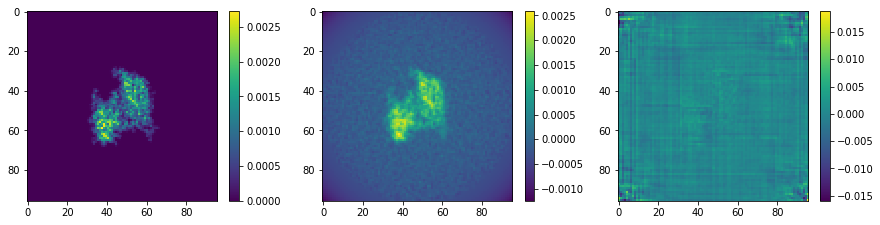

In [24]:
visualize(ground_truth_tensor=gt_tensor, noisy_tensor=noisy_tensor, result_tensor=denoised)